In [1]:
pip install python-gdcm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 29.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# !pip install pydicom
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt

import os
import cv2
import glob
import gdcm
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from imblearn.over_sampling import SMOTE

import pickle 

import os
import cv2

from sklearn.utils import shuffle
from tqdm import tqdm

# !pip install pylibjpeg
# import pylibjpeg

import warnings
warnings.filterwarnings('ignore')

from skimage import transform

In [3]:
# Meta Data Import
train_df=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

# Get image path
# Example path: '/kaggle/input/rsna-breast-cancer-detection/train_images/10706/763186195.dcm'
base_path = "/kaggle/input/rsna-breast-cancer-detection/train_images/"
all_paths = []
for k in tqdm(range(len(train_df))):
    row = train_df.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".dcm")
    
train_df["path"] = all_paths
train_df.head()

100%|██████████| 54706/54706 [00:09<00:00, 5571.60it/s]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...


In [4]:
train_df['biopsy'].value_counts()

0    51737
1     2969
Name: biopsy, dtype: int64

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  path                  

In [6]:
train_df['patient_id'].nunique()

11913

# Build the training dataset

In [7]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...


## Check if a single patient xray has cancer in both breasts or only in one

In [8]:
train_df[train_df['cancer']==1]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
190,1,10226,461614796,L,MLO,71.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,R,MLO,56.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54593,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54594,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54595,2,9851,1409270544,L,MLO,58.0,1,1,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-detection/tra...


In [9]:
train_df[train_df['patient_id']==9840]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
54591,2,9840,87146266,L,MLO,59.0,0,1,0,NaN,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...
54592,2,9840,629749649,L,CC,59.0,0,1,0,NaN,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...
54593,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54594,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...


> we can see for patient id 9840, she has cancer in right breast only

## Check how many images have cancer

In [10]:
train_df['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

In [11]:
train_df['density'].value_counts()

B    12651
C    12175
A     3105
D     1539
Name: density, dtype: int64

In [12]:
train_df[(train_df['laterality'] == 'L') 
         & (train_df['difficult_negative_case'] == False) 
         & (train_df['density'].isin(['A','B']))].cancer.value_counts()

0    6477
1     198
Name: cancer, dtype: int64

## Build a data set of by sampling random number of patients with and without cancer

In [13]:
majority_class_df=train_df[(train_df['cancer'] == 1) 
                           & (train_df['difficult_negative_case'] == False) 
                           & (train_df['density'].isin(['A','B']))].sample(200)
minority_class_df=train_df[(train_df['cancer'] == 0)
                           & (train_df['difficult_negative_case'] == False) 
                           & (train_df['density'].isin(['A','B']))].sample(100)

final_df = pd.concat([majority_class_df, minority_class_df])

final_df=final_df.reset_index(drop=True)
final_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,1109,1869230850,R,MLO,57.0,1,1,1,0.0,0,B,170,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,1,3626,293937906,L,MLO,82.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,1,47280,1058632970,L,CC,65.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,1,44676,1346493294,L,MLO,64.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,1,63053,1562088774,R,MLO,54.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...


## Split the images into training data sets
-> Make 2 folders
* 0: Healthy Patients 
* 1: Cancer Patients 

In [14]:
import os
import pydicom
import cv2
import concurrent.futures
from tqdm import tqdm

output_folder = "/kaggle/working/train_images"

# Create healthy and cancer sub-folders inside output_folder
healthy_folder = os.path.join(output_folder, "healthy")
if not os.path.exists(healthy_folder):
    os.makedirs(healthy_folder)

cancer_folder = os.path.join(output_folder, "cancer")
if not os.path.exists(cancer_folder):
    os.makedirs(cancer_folder)

def process_image(row):
    src_path = row['path']
    patient_id = row['patient_id']
    image_id = row['image_id']

    # Load the DICOM image
    dicom = pydicom.dcmread(src_path)
    
    img = dicom.pixel_array
    img = (img - img.min()) / (img.max() - img.min())
    img = cv2.resize(img, (256, 256))
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img

    # Determine the target folder based on the cancer column value
    if row['cancer'] == 0:
        target_folder = healthy_folder
    else:
        target_folder = cancer_folder

    # Construct the target path
    target_path = os.path.join(target_folder, f"{patient_id}_{image_id}.png")

    # Save the image to the target folder
    cv2.imwrite(target_path, (img * 255).astype(np.uint8))

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, row) for index, row in final_df.iterrows()]
    for f in tqdm(concurrent.futures.as_completed(futures), total=final_df.shape[0]):
        pass

100%|██████████| 300/300 [03:01<00:00,  1.66it/s]


## Count images in sub folders

In [15]:
# def show_folder_contents(folder_path):
#     for filename in os.listdir(folder_path):
#         print(filename)

# folder_path = "/kaggle/working/train_images/cancer"
# show_folder_contents(folder_path)

In [16]:
import os

def count_images(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            count += 1
    return count

folder_path = "/kaggle/working/train_images/cancer"
image_count = count_images(folder_path)
print("Number of images in cancer folder:", image_count)

folder_path = "/kaggle/working/train_images/healthy"
image_count = count_images(folder_path)
print("Number of images in healthy folder:", image_count)

Number of images in cancer folder: 200
Number of images in healthy folder: 100


## View images in subfolder

In [17]:
import os
import matplotlib.pyplot as plt
    
def view_images_in_both_subfolders(folder_path, num_images=5):
    fig, ax = plt.subplots(nrows=2, ncols=num_images, figsize=(20, 10))
    class_folders = ["healthy", "cancer"]
#     class_folders = ["healthy_corrected", "cancer_corrected"]
    for j, class_folder in enumerate(class_folders):
        class_folder_path = os.path.join(folder_path, class_folder)
        file_names = os.listdir(class_folder_path)
        
        for i, file_name in enumerate(file_names[:num_images]):
                image = plt.imread(os.path.join(class_folder_path, file_name))
                ax[j, i].imshow(image, cmap='jet')
                ax[j, i].set_title(f"{class_folder} - Image Shape: {image.shape}")

    plt.show();

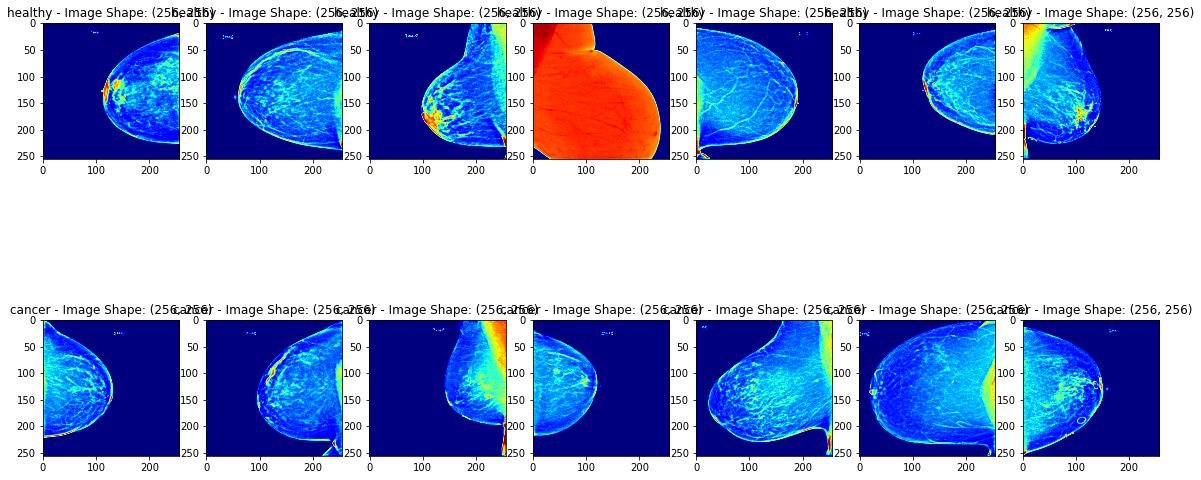

In [18]:
view_images_in_both_subfolders("/kaggle/working/train_images", num_images=7)

In [19]:
# def normalize_image(img):
#     img = img / np.max(img)
#     return img

# def normalize_folder(folder_path):
#     for subdir, dirs, files in os.walk(folder_path):
#         for file in files:
#             file_path = os.path.join(subdir, file)
#             img = cv2.imread(file_path, 0)
#             img = normalize_image(img)
#             cv2.imwrite(file_path, img)

# healthy_folder = "/kaggle/working/train_images/healthy"
# cancer_folder = "/kaggle/working/train_images/cancer"

# normalize_folder(healthy_folder)
# normalize_folder(cancer_folder)

In [20]:
def check_normalization(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if np.min(img) < 0 or np.max(img) > 1:
            print("Image not normalized:", np.min(img), np.max(img), img.shape, file_path)
        else:
            print("Image normalized:", np.min(img), np.max(img), img.shape, file_path)

# folder_path = "/kaggle/working/train_images/cancer"
# print('Cancer images check ===========')
# check_normalization(folder_path)

# folder_path = "/kaggle/working/train_images/healthy"
# print('\nHealthy images check ===========')
# check_normalization(folder_path)

# Preprocess the images

### Read nth image in a folder

In [21]:
def read_nth_image(folder_path, n):
    images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    if len(images) < n:
        return None
    else:
        image_path = os.path.join(folder_path, images[n-1])
        image = cv2.imread(image_path)
        return image

In [22]:
folder_path='/kaggle/working/train_images/cancer/'
n=4
img=read_nth_image(folder_path, n)

In [23]:
img.shape, img.min(), img.max()

((256, 256, 3), 0, 255)

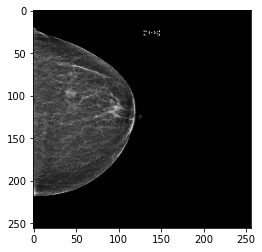

In [24]:
plt.imshow(img, cmap='gray');

### Apply preprocessing to just 1 image to see the changes

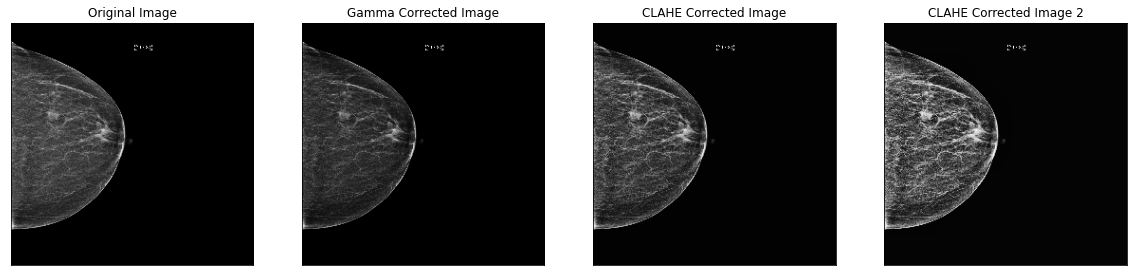

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)], dtype="uint8")

    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(image)
    
    # apply gamma correction to each color channel
    corrected_R = cv2.LUT(R, table)
    corrected_G = cv2.LUT(G, table)
    corrected_B = cv2.LUT(B, table)
    
    # merge the corrected color channels back into a single image
    corrected_image = cv2.merge((corrected_R, corrected_G, corrected_B))
    
    return corrected_image

def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(img)
    
    # apply CLAHE to each color channel
    cl1_R = clahe.apply(R)
    cl1_G = clahe.apply(G)
    cl1_B = clahe.apply(B)
    
    # merge the corrected color channels back into a single image
    cl1 = cv2.merge((cl1_R, cl1_G, cl1_B))
    
    return cl1

# Perform gamma correction with gamma=0.5
gamma_corrected_image = adjust_gamma(img, 0.8)

# Apply CLAHE
clahe_corrected_image = apply_clahe(gamma_corrected_image, clip_limit=1.0, tile_grid_size=(8,8))

# Apply CLAHE
clahe_corrected_image_2 = apply_clahe(clahe_corrected_image, clip_limit=1.0, tile_grid_size=(8,8))

# Display original, gamma corrected, and CLAHE corrected images
plt.figure(figsize=(20,8))
plt.subplot(1,4,1),plt.imshow(img,cmap="gray")
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,2),plt.imshow(gamma_corrected_image,cmap="gray")
plt.title("Gamma Corrected Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,3),plt.imshow(clahe_corrected_image,cmap="gray")
plt.title("CLAHE Corrected Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,4),plt.imshow(clahe_corrected_image_2,cmap="gray")
plt.title("CLAHE Corrected Image 2"), plt.xticks([]), plt.yticks([])

plt.show()

### Define preprocessing functions to modify the images in the target fodlers 

In [26]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)], dtype="uint8")

    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(image)
    
    # apply gamma correction to each color channel
    corrected_R = cv2.LUT(R, table)
    corrected_G = cv2.LUT(G, table)
    corrected_B = cv2.LUT(B, table)
    
    # merge the corrected color channels back into a single image
    corrected_image = cv2.merge((corrected_R, corrected_G, corrected_B))
    
    return corrected_image

def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(img)
    
    # apply CLAHE to each color channel
    cl1_R = clahe.apply(R)
    cl1_G = clahe.apply(G)
    cl1_B = clahe.apply(B)
    
    # merge the corrected color channels back into a single image
    cl1 = cv2.merge((cl1_R, cl1_G, cl1_B))
    
    return cl1

cancer_folder = "/kaggle/working/train_images/cancer/"
healthy_folder = "/kaggle/working/train_images/healthy/"

def process_images(folder_path):
    for filename in os.listdir(folder_path):
        print(os.path.join(folder_path, filename))
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            image = cv2.imread(os.path.join(folder_path, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert from BGR to RGB
            image = adjust_gamma(image)
            image = apply_clahe(image)
            image = apply_clahe(image)
            cv2.imwrite(os.path.join(folder_path, filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [27]:
process_images(cancer_folder)
process_images(healthy_folder)

/kaggle/working/train_images/cancer/65244_119855018.png
/kaggle/working/train_images/cancer/30836_714251521.png
/kaggle/working/train_images/cancer/43004_2086414198.png
/kaggle/working/train_images/cancer/2938_247535701.png
/kaggle/working/train_images/cancer/24643_333469112.png
/kaggle/working/train_images/cancer/41359_1802579446.png
/kaggle/working/train_images/cancer/31582_564250417.png
/kaggle/working/train_images/cancer/28785_52731467.png
/kaggle/working/train_images/cancer/64018_259642159.png
/kaggle/working/train_images/cancer/59806_2119940867.png
/kaggle/working/train_images/cancer/15078_1719011144.png
/kaggle/working/train_images/cancer/21880_2124340393.png
/kaggle/working/train_images/cancer/43004_1829769663.png
/kaggle/working/train_images/cancer/45666_1879230222.png
/kaggle/working/train_images/cancer/65077_545603591.png
/kaggle/working/train_images/cancer/47382_2129270210.png
/kaggle/working/train_images/cancer/12305_1995339680.png
/kaggle/working/train_images/cancer/21445

In [28]:
folder_path = "/kaggle/working/train_images/cancer"
image_count = count_images(folder_path)
print("Number of images in cancer folder:", image_count)


folder_path = "/kaggle/working/train_images/healthy"
image_count = count_images(folder_path)
print("Number of images in healthy folder:", image_count)

Number of images in cancer folder: 200
Number of images in healthy folder: 100


# Baseline CNN Model

In [29]:
import tensorflow as tf
tf.config.threading.set_inter_op_parallelism_threads(4)

## Augment the data

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import rotate
from sklearn.metrics import roc_auc_score

# set the seed
tf.random.set_seed(42)

# set path to data directory
train_dir='/kaggle/working/train_images'

train_data = ImageDataGenerator(
                                # set data augmentation parameters
#                                 preprocessing_function=custom_augmentation,
                                rescale=1./255,
                                rotation_range=45,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest'
).flow_from_directory(
                      directory=train_dir,
                      batch_size=16,
                      target_size=(256,256),
                      color_mode='rgb',
                      class_mode='binary',
                      seed=42
                    )

Found 300 images belonging to 2 classes.


## Run the CNN Model

In [31]:
# 1. Basic Model
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Reshape((256, 256, 3), input_shape=(256, 256, 3)),
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, 
                         activation="relu"), 
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2), 
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), 
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") 
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# split the data into training and validation sets
val_split = 0.2
x_data, y_data = [], []
for x, y in train_data:
    x_data.append(x)
    y_data.append(y)
    if len(x_data) >= (1 - val_split) / train_data.batch_size:
        break
x_train = np.concatenate(x_data)
y_train = np.concatenate(y_data)
x_val = next(train_data)[0]
y_val = next(train_data)[1]

# fit the model using the training data
history_1 = model_1.fit(x_train, y_train,
                        epochs=20,
                        validation_data=(x_val, y_val))

# evaluate the model on the validation data
val_loss, val_acc = model_1.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# calculate AUC score
y_pred = model_1.predict(x_val)
auc = roc_auc_score(y_val, y_pred)
print("AUC Score:", auc)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.6953 - accuracy: 0.4375 - val_loss: 0.7244 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 353ms/step - loss: 0.5950 - accuracy: 0.7500 - val_loss: 0.8342 - val_accuracy: 0.4375
Epoch 3/20
1/1 [==============================] - 0s 340ms/step - loss: 0.5161 - accuracy: 0.7500 - val_loss: 1.0248 - val_accuracy: 0.3750
Epoch 4/20
1/1 [==============================] - 0s 326ms/step - loss: 0.4581 - accuracy: 0.7500 - val_loss: 1.1965 - val_accuracy: 0.3125
Epoch 5/20
1/1 [==============================] - 0s 334ms/step - loss: 0.4033 - accuracy: 0.7500 - val_loss: 1.2907 - val_accuracy: 0.3125
Epoch 6/20
1/1 [==============================] - 0s 338ms/step - loss: 0.3399 - accuracy: 0.8750 - val_loss: 1.3690 - val_accuracy: 0.3125
Epoch 7/20
1/1 [==============================] - 0s 332ms/step - loss: 0.2775 - accuracy: 0.8750 - val_loss: 1.5297 - val_accuracy: 0.1875
Epoch 8/20
1/1 [=======

# Inception-v3 Model

In [32]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

# Load the Inception-v3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all layers of the Inception-v3 model
for i, layer in enumerate(base_model.layers):
    if i >= 10:  # change this number to select the layer index to start unfreezing from
        layer.trainable = True

# Create a new sequential model
model = tf.keras.models.Sequential()

# Add the pre-trained Inception-v3 model to the new sequential model
model.add(base_model)

# Add a new GlobalAveragePooling2D layer to the new sequential model
model.add(GlobalAveragePooling2D())

# Add a new dense layer with 2048 neurons and ReLU activation to the new sequential model
model.add(Dense(2048, activation='relu'))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add a new dense layer with 1 neuron and sigmoid activation to the new sequential model
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adagrad(), metrics=["accuracy"])

# Model checkpoint
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

# Learning rate schedule
def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 5:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Fit the model using the training data
history = model.fit(x_train, y_train,
                    epochs=20,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint, lr_scheduler])

# # Load the best model
model = tf.keras.models.load_model('model.h5')

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# Calculate the AUC score
y_pred = model.predict(x_val)
auc = roc_auc_score(y_val, y_pred)
print("AUC Score:", auc)


87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/20
1/1 [==============================] - 18s 18s/step - loss: 0.7739 - accuracy: 0.4375 - val_loss: 0.5902 - val_accuracy: 0.7500
Epoch 2/20
1/1 [==============================] - 5s 5s/step - loss: 0.7104 - accuracy: 0.5625 - val_loss: 0.5924 - val_accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 6s 6s/step - loss: 0.6100 - accuracy: 0.6250 - val_loss: 0.5939 - val_accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 5s 5s/step - loss: 0.5962 - accuracy: 0.6875 - val_loss: 0.5951 - val_accuracy: 0.7500
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 0.5906 - accuracy: 0.7500 - val_loss: 0.5949 - val_accuracy: 0.8125
Epoch 6/20
1/1 [==============================] - 5s 5s/step - loss: 0.6239 - accuracy: 0.6250 - val_loss: 0.5954 - val_accuracy: 0.8125
Epoch 7/20
1/1 [==============================] - 5s 5s/step - loss: 0.5680 - accuracy: 0.7500 - val_loss: 0.59

In [33]:
# Save the model
model.save('my_model.h5')

In [34]:
test=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [35]:
sample=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv')
sample

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [36]:
import pydicom
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved model
model = tf.keras.models.load_model('my_model.h5')

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test images
image_path = '/kaggle/input/rsna-breast-cancer-detection/test_images/10008'
image_files = os.listdir(image_path)

images = []
for file in image_files:
    dcm = pydicom.read_file(os.path.join(image_path, file))
    img = dcm.pixel_array.astype(float)
    img -= np.min(img)
    img /= np.max(img)
    img = np.stack((img,)*3, axis=-1)  # Convert grayscale to RGB
    images.append(img)

images = np.array(images)

# Preprocess the test data using the test data generator
test_data = test_datagen.flow(images, batch_size=1, shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_data)

image_ids = [file.replace('.dcm', '') for file in image_files]
df = pd.DataFrame({'image_id': image_ids, 'cancer': predictions.reshape(-1)})

print(df)

     image_id    cancer
0   736471439  0.459810
1   361203119  0.462269
2    68070693  0.456921
3  1591370361  0.465794


In [37]:
# Convert image_id column to string in both dataframes
test['image_id'] = test['image_id'].astype(str)
df['image_id'] = df['image_id'].astype(str)

# Merge the dataframes on image_id
merged_df = pd.merge(test, df, on='image_id')


In [38]:
merged_df=merged_df[['prediction_id', 'cancer']]
merged_df

,prediction_id,cancer
0,10008_L,0.459810
1,10008_L,0.465794
2,10008_R,0.456921
3,10008_R,0.462269


In [39]:
merged_df=merged_df.sort_values(by='cancer', ascending=False, axis=0)
merged_df

,prediction_id,cancer
1,10008_L,0.465794
3,10008_R,0.462269
0,10008_L,0.459810
2,10008_R,0.456921


In [40]:
submission = merged_df.groupby('prediction_id')['cancer'].max()
submission = pd.DataFrame(submission).reset_index()
submission.to_csv('/kaggle/working/submission.csv', index=False)